# Air Pollution Dataset Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns

from utils import *

datasets_folder = './datasets'

## Data Reading

In [2]:
air_pollution_dataset = os.path.join(datasets_folder,'pollution/pollution.csv')

air_pollution_df = pd.read_csv(air_pollution_dataset, sep=';')
air_pollution_df.rename(columns={
    'COD_STAZ': 'Station', 
    'AGENTE': 'Agent', 
    'DATA_INIZIO': 'Date', 
    'DATA_FINE': 'Ending_date', 
    'VALORE': 'Value', 
    'UM': 'Unit'
}, inplace=True)

air_pollution_df.drop(columns=['Ending_date'], inplace=True)
air_pollution_df=air_pollution_df.sort_values(by='Date')
air_pollution_df['Date'] = pd.to_datetime(air_pollution_df['Date'].apply(lambda x: ' '.join(x.split('T')).split('+')[0]))
air_pollution_df['Date'] = air_pollution_df['Date'].apply(lambda x: x - timedelta(minutes=x.minute)) # round to the hour
air_pollution_df = air_pollution_df.set_index('Date')
air_pollution_df['Agent'] = air_pollution_df['Agent'].apply(lambda x: x.split(' ')[0])

air_pollution_df.head(5)

,Station,Agent,Value,Unit
Date,,,,
2019-01-01,GIARDINI MARGHERITA,PM2.5,37.0,ug/m3
2019-01-01,GIARDINI MARGHERITA,PM10,50.0,ug/m3
2019-01-01,PORTA SAN FELICE,PM2.5,41.0,ug/m3
2019-01-01,VIA CHIARINI,O3,0.0,ug/m3
2019-01-01,VIA CHIARINI,NO2,20.0,ug/m3


Let's check the Unit of each agent

In [3]:
air_pollution_df.groupby([ 'Agent','Unit']).size().reset_index(name='counts').drop(columns='counts')

,Agent,Unit
0,C6H6,ug/m3
1,CO,mg/m3
2,NO,ug/m3
3,NO2,ug/m3
4,NOX,ug/m3
5,O3,ug/m3
6,PM10,ug/m3
7,PM2.5,ug/m3


In [4]:
agents = np.unique(air_pollution_df['Agent'])
stations = np.unique(air_pollution_df['Station'])

station_dfs = {s:air_pollution_df[air_pollution_df['Station'] == s] for s in stations}

## Missing Values


Check gaps in the data

In [ ]:
s=stations[0]
print(f'Station {s}:')
for agent in np.unique(station_dfs[s]['Agent']):
    print(f' - Agent: {agent}')
    mask=(station_dfs[s]['Agent']==agent)
    timedeltas_hours = station_dfs[s]['Date'][mask].diff().dt.total_seconds()[1:] / 3600  # Convert to hours
    display(pd.DataFrame(timedeltas_hours.value_counts()).transpose())

Station GIARDINI MARGHERITA:
 - Agent: NO2


KeyError: 'Date'

In [ ]:
s=stations[1]
print(f'Station {s}:')
for agent in np.unique(station_dfs[s]['Agent']):
    print(f' - Agent: {agent}')
    mask=(station_dfs[s]['Agent']==agent)
    timedeltas_hours = station_dfs[s]['Date'][mask].diff().dt.total_seconds()[1:] / 3600  # Convert to hours
    display(pd.DataFrame(timedeltas_hours.value_counts()).transpose())

In [ ]:
s=stations[2]
print(f'Station {s}:')
for agent in np.unique(station_dfs[s]['Agent']):
    print(f' - Agent: {agent}')
    mask=(station_dfs[s]['Agent']==agent)
    timedeltas_hours = station_dfs[s]['Date'][mask].diff().dt.total_seconds()[1:] / 3600  # Convert to hours
    display(pd.DataFrame(timedeltas_hours.value_counts()).transpose())

## Resampling

Resample (modify dataframe to have a dense index and add also to each row the missing values for station and Unit(not really necessary anyway))
PM are resampled at 24h, other agents at 1h

In [5]:
agents_dict = {
    'PM10': '24h',
    'PM2.5': '24h',
    'CO': '1h',
    'O3': '1h',
    'NO': '1h',
    'NO2': '1h',
    'NOX': '1h',
    'C6H6': '1h'
}

resampled_san_felice_df = resample_df_on_column(station_dfs[stations[1]], agents_dict)
resampled_san_felice_df[resampled_san_felice_df['Agent'] == 'NO2'].head()


Resampling for station "PORTA SAN FELICE..."


KeyError: 'Date'

Added the missing rows but still the value is Nan

In [ ]:
start_date=datetime(2019,1,1)
end_date=datetime(2019,1,7)

to_plot = resampled_san_felice_df[resampled_san_felice_df['Agent']=='CO']

# plot_time_series([giardini_df[giardini_df['Agent']=='CO']], 'Value', 'Date', legends=['CO'], start_date=start_date, end_date=end_date, title='Original Data')
plot_time_series([to_plot], 'Value', 'Date', legends=['CO'], start_date=start_date, end_date=end_date, title='Resampled Data')

In [ ]:
start_date=datetime(2022,1,1)
end_date=datetime(2025,1,1)

# display the gaps of at lest 5 hours of NO2
plot_missing_value_gaps(to_plot,start_date=start_date, end_date=end_date,
                         min_gap=5, surrounding_vals=20)

Check the amount of missing data for each agent.

In [ ]:
for agent in np.unique(resampled_san_felice_df['Agent']):
    count = resampled_san_felice_df[resampled_san_felice_df['Agent']==agent].isna().sum()['Value']
    tot = len(resampled_san_felice_df[resampled_san_felice_df['Agent']==agent])
    print(f'Agent {agent}: {count}({count/tot:.4f}%) missing Values')

## Filling Missing Values

Even if the data missing is small, oftentimes they create a big gap of missing values. We will try to reconstruct it to a somewhat reasonable behaviour.

### Full Process

For each agent, we train a model to reconstruct the missing values.

#### Time Period

the prof had 5 min sampling and used 8 days... we have 60 minutes so... 3 months (?)

Looking at the plots, most of 2023 and 2024 havent got big gaps, but also early 2019/2023 and late 2022. Let's try november 2022 to february 2023.

Edit: mi sa non bastano?? allungo un po


In [ ]:
start = datetime(2022,4,5,8)
end = datetime(2022,6,30)
end-start

We are going to work with NO2 data.

In [ ]:
resampled_giardini_df['Date_idx'] = np.arange(len(resampled_giardini_df))

In [ ]:
segment = resampled_giardini_df[(resampled_giardini_df['Agent']=='NO2')&(resampled_giardini_df['Date']>=start)&(resampled_giardini_df['Date']<end)]
display(segment.isna().sum())
# display(segment)

#### Train and Test set

The segment has only 4 missing values, so we choose a good period... Let's drop these rows and prepare a training and test set.

In [ ]:
tmp = segment.copy()
tmp = tmp.dropna()
tmp

In [ ]:
np.random.seed(42)
idx = np.arange(len(tmp))
np.random.shuffle(idx[1:-1]) # do not shuffle the first/last point
t = idx[1]; idx[1] = idx[-1]; idx[-1] = t # keep first/last points in the left half (??????????????????????????????????????????????????????????????????????????)

split=0.8 # maybe a bit more than 2/3 since that there are little missing values? 
sep = int(len(idx) * split)
train_data = tmp.iloc[idx[:sep]]
test_data = tmp.iloc[idx[sep:]]

In [ ]:
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.gaussian_process.kernels import ExpSineSquared, DotProduct, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm

figsize=(20,4)

#### First kernel

In [ ]:
kernel = WhiteKernel(1e-3, (1e-4, 1e2))
kernel += ConstantKernel(1, (1e-2, 5e3)) * RBF(1, (1e-1, 1e1))

np.random.seed(42)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3)
gp.fit(train_data[['Date_idx']], train_data['Value'])
print(gp.kernel_)

In [ ]:
pred, std = gp.predict(segment[['Date_idx']], return_std=True)
pred = pd.Series(index=segment.index, data=pred)
std = pd.Series(index=segment.index, data=std)

In [ ]:
plot_gp(target_samples=test_data['Value'], samples=train_data['Value'], pred=pred, std=std, figsize=figsize)

In [ ]:
# Obtain predictions for the validation data
pred_ts = pred[test_data.index]
std_ts = std[test_data.index]

ldens = norm.logpdf(test_data['Value'], pred_ts, std_ts)
ll = np.sum(ldens)
print(f'Log likelihood of the validation set: {ll:.2f}')

#### Second Kernel

In [ ]:
kernel = WhiteKernel(1e-3, (1e-4, 1e2))
kernel += ConstantKernel(1, (1e-2, 1e3)) * RBF(1, (1e-1, 1e1))
kernel += ConstantKernel(1, (1e-2, 1e3)) * ExpSineSquared(1, 2000, (1e-1, 1e1), (900, 2100))

np.random.seed(42)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3)
gp.fit(train_data[['Date_idx']], train_data['Value'])
print(gp.kernel_)

In [ ]:
pred, std = gp.predict(segment[['Date_idx']], return_std=True)
pred = pd.Series(index=segment.index, data=pred)
std = pd.Series(index=segment.index, data=std)

In [ ]:
plot_gp(target_samples=test_data['Value'], samples=train_data['Value'], pred=pred, std=std, figsize=figsize)
ldens = norm.logpdf(test_data['Value'], pred[test_data.index], std[test_data.index])
print(f'Log likelihood of the validation set: {np.sum(ldens):.2f}')

#### sezione strana sulla std

#### Full data filling

***NOTE** : just NO2*

In [ ]:
start_date=datetime(2022,3,20)
end_date=datetime(2022,4,30)

no2_df = resampled_giardini_df[(resampled_giardini_df['Agent']=='NO2')&(resampled_giardini_df['Date']>=start_date)&(resampled_giardini_df['Date']<=end_date)]
len(no2_df)

In [ ]:
gp2 = GaussianProcessRegressor(kernel=gp.kernel_, optimizer=None)
tmp = no2_df.dropna() # The whole series (NaNs excluded)
gp2.fit(tmp[['Date_idx']], tmp['Value'])
pred_all, std_all = gp2.predict(no2_df[['Date_idx']], return_std=True)
pred_all = pd.Series(index=no2_df.index, data=pred_all)
std_all = pd.Series(index=no2_df.index, data=std_all)

predictions :(

In [ ]:
plot_gp(samples=no2_df['Value'], pred=pred_all, std=std_all, figsize=figsize)

### Final Function

In [ ]:
model = {
    
}

filled_giardini_df = fill_missing_dates_on_column_value(resampled_giardini_df, column_to_fill='Value', mode='model', model_settings=model)
filled_giardini_df.isna().sum()

In [ ]:
agent_dfs = df_to_agents_dict(filled_giardini_df)

## **AQI**

For each station we develop a model to describe the air pollution. Given that each station collects different data, and sometimes with different intensities, we decided to treat each station indepentendtely.

Air polution follows this criteria:
- for each pollutant a certain limit is defined (like 25 µg/m³ for PM2.5)
- for each pollutant $ AQI = \frac{Concentration}{Limit} \times 100 $
- take the maximum value across all the IQAs 

The overage value is then matched on the following table:

| **AQI**         | **CONDITIONS** |
| --------------- | -------------- |
| <50             | EXCELLENT      |
| From 50 to 99   | GOOD           |
| From 100 to 149   | FAIR           |
| From 150 to 200  | POOR           |
| >200            | VERY POOR      |

We are going to model each agent to predict its hour value and then use all of the predictions to compute the overall Air Quality Index and compare it with the one got from the readings.

<table class="pure-table legenda">
    <thead>
        <tr class="main"><th colspan="5">Limiti di riferimento per gli inquinanti monitorati (D.Lgs.155/2010)</th></tr>
        <tr>
            <th>Inquinante</th>
            <th>Limite</th>
            <th>Periodo di mediazione</th>
            <th>Limite</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>PM10 (µg/m<sup>3</sup>)</td>
            <td data-column="Limite">Valore limite giornaliero</td>
            <td data-column="Media">Media giornaliera</td>
            <td data-column="Limite">50 µg/m<sup>3</sup></td>
        </tr>
        <tr>
            <td><abbr title="Biossido di azoto">NO<sub>2</sub></abbr> (µg/m<sup>3</sup>)</td>
            <td data-column="Limite">Valore limite orario</td>
            <td data-column="Media">Media oraria</td>
            <td data-column="Limite">200 µg/m<sup>3</sup></td>
        </tr>
        <tr>
            <td rowspan="3"><abbr title="Ozono">O<sub>3</sub></abbr> (µg/m<sup>3</sup>)</td>
            <td data-column="Limite">Soglia d'informazione</td>
            <td data-column="Media">Media oraria</td>
            <td data-column="Limite">180 µg/m<sup>3</sup></td>
        </tr>
        <tr>
            <td>Soglia d'allarme</td>
            <td data-column="Media">Media oraria</td>
            <td data-column="Limite">240 µg/m<sup>3</sup></td>
        </tr>
        <tr>
            <td>Valore obiettivo</td>
            <td data-column="Media">Massima delle medie mobili su 8 ore</td>
            <td data-column="Limite">120 µg/m<sup>3</sup></td>
        </tr>
        <tr>
            <td><abbr title="Monossido di carbonio">CO</abbr> (mg/m<sup>3</sup>)</td>
            <td data-column="Limite">Valore limite</td>
            <td data-column="Media">Massima delle medie mobili su 8 ore</td>
            <td data-column="Limite">10 mg/m<sup>3</sup></td>
        </tr>
        <tr>
            <td><abbr title="Biossido di zolfo">SO<sub>2</sub></abbr> (µg/m<sup>3</sup>)</td>
            <td data-column="Limite">Valore limite giornaliero</td>
            <td data-column="Media">Media giornaliera</td>
            <td data-column="Limite">125 µg/m<sup>3</sup></td>
        </tr>
        <tr>
            <td>PM2.5 (µg/m<sup>3</sup>)</td>
            <td data-column="Limite">Valore limite su base annua</td>
            <td data-column="Media">Media giornaliera</td>
            <td data-column="Limite">25 µg/m<sup>3</sup></td>
        </tr>
        <tr>
            <td>Benzene (µg/m<sup>3</sup>)</td>
            <td data-column="Limite">Valore limite su base annua</td>
            <td data-column="Media">Media giornaliera</td>
            <td data-column="Limite">5 µg/m<sup>3</sup></td>
        </tr>
    </tbody>
</table>

*source: [ARPAE](https://apps.arpae.it/qualita-aria/bollettino-qa-provinciale/bo)*

### Agents

Let's inspect our agents:

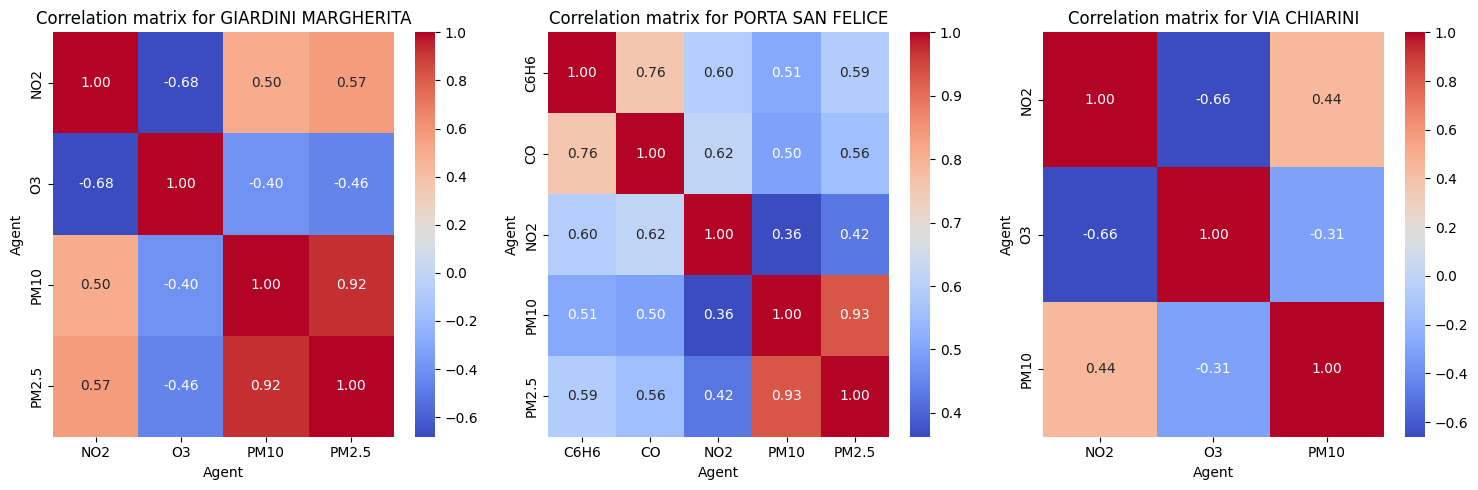

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, s in enumerate(stations):
    corr_matrix = station_dfs[s].pivot_table(index='Date', columns='Agent', values='Value').corr()
    axes[i].set_title(f'Correlation matrix for {s}')
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[i])

plt.tight_layout()
plt.show()

In the AQI standard NO and NOX are not present. NOX is simply a short-hand for both NO and NO2, in fatcs it is higly correlated with both of them. We can safely drop it because it is not useful and we already have its informations.

Even if NO is different form NO2, it is not used to predict the Air Quality Index, so we choose to ignore it in our models.

In [27]:
for s in stations:
    station_dfs[s] = station_dfs[s][~station_dfs[s]['Agent'].isin(['NO','NOX'])]

### Visualization

In [48]:
pollutant_limits = {
    'PM2.5': 40,    # µg/m³
    'PM10': 50,     # µg/m³
    'CO': 10,       # mg/m³
    'O3': 120,      # µg/m³
    'NO2': 200,     # µg/m³
    'C6H6': 5       # µg/m³
}

In [49]:
station_dicts = {s:df_to_agents_dict(station_dfs[s].drop(columns=['Unit']), drop_agents=True, drop_stations=True) for s in stations}
for k in station_dicts:
    print(f'Agents in station {k}:',end='\n -')
    print(*list(station_dicts[k].keys()),sep=',')

Splitting station "GIARDINI MARGHERITA"...
Splitting station "PORTA SAN FELICE"...
Splitting station "VIA CHIARINI"...
Agents in station GIARDINI MARGHERITA:
 -NO2,O3,PM10,PM2.5
Agents in station PORTA SAN FELICE:
 -C6H6,CO,NO2,PM10,PM2.5
Agents in station VIA CHIARINI:
 -NO2,O3,PM10


For each station construct the daily and hourly AQI for each agent.

In [55]:
station_AQIs_daily = {
    s: {agent: get_AQI(station_dicts[s][agent], 
                        agent=agent, 
                        period='day', 
                        value_column='Value',
                        limit=pollutant_limits[agent], 
                        ) for agent in station_dicts[s].keys()} for s in station_dicts
}
station_AQI_daily = merge_AQIs(station_AQIs_daily, period='day')

station_AQIs_hourly = {
    s: {agent: get_AQI(station_dicts[s][agent],
                       agent=agent,
                       period='hour', 
                       value_column='Value',
                       limit=pollutant_limits[agent],
                       include_hourly_pm=True
                       ) for agent in station_dicts[s].keys()} for s in station_dicts
}
station_AQI_hourly = merge_AQIs(station_AQIs_hourly, period='hour')

Station GIARDINI MARGHERITA AQI:


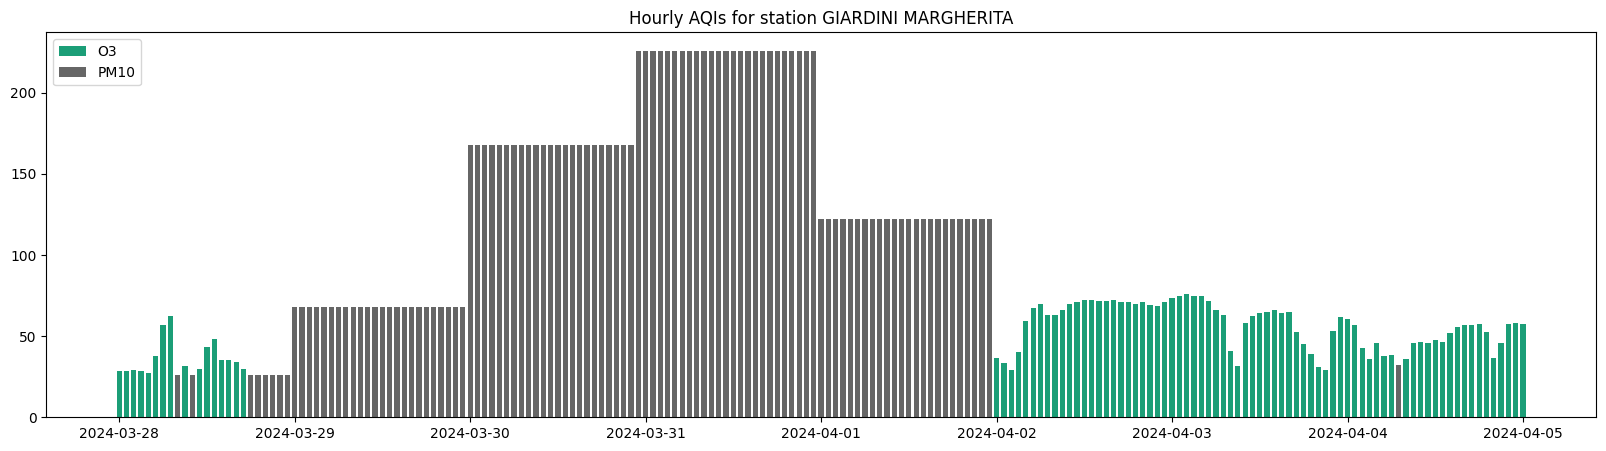

Station PORTA SAN FELICE AQI:


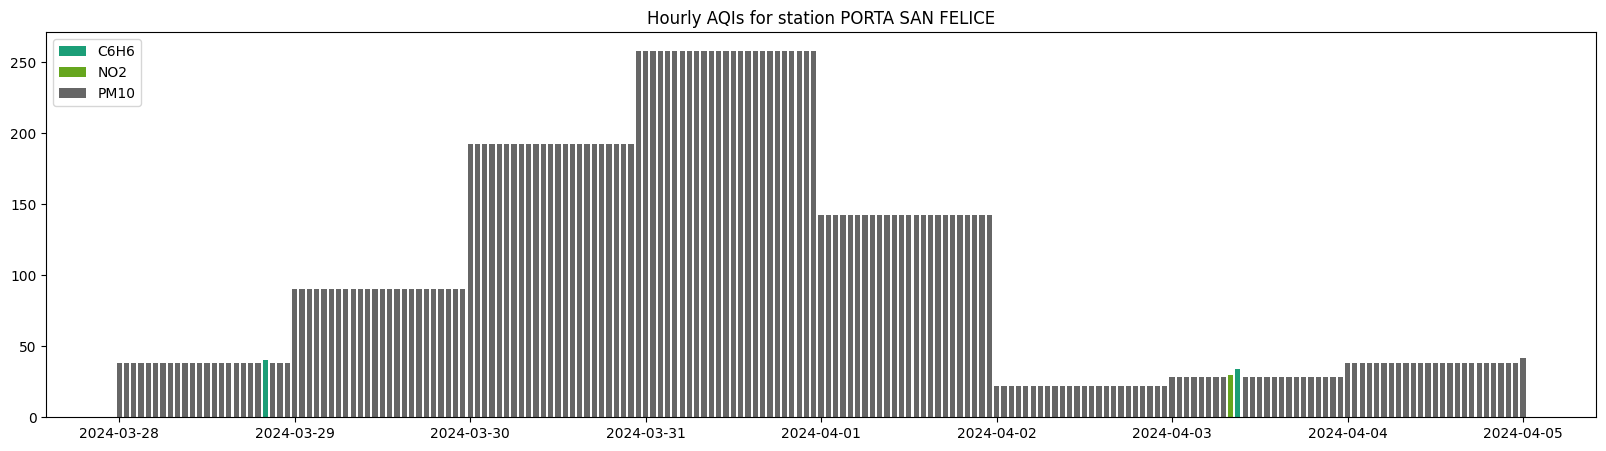

Station VIA CHIARINI AQI:


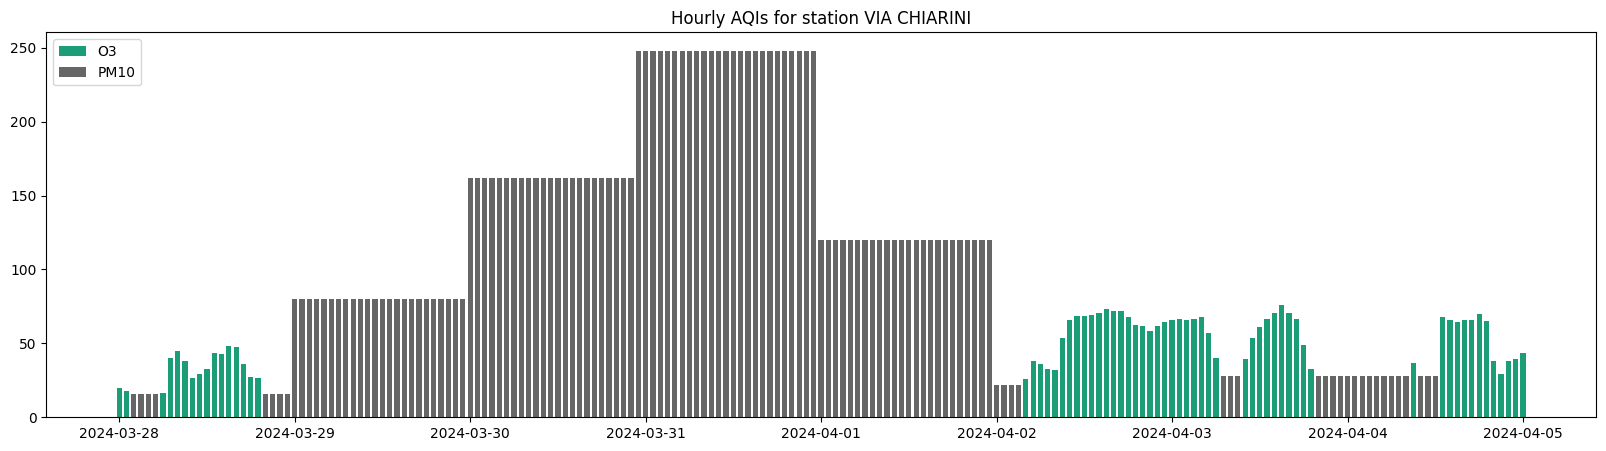

In [ ]:
start=datetime(2024,3,28)
end=datetime(2024,4,5)

for station in station_AQIs_hourly:
    print(f'Station {station} AQI:')

    plot_AQI(
        station_AQI=[
            station_AQI_hourly[station],
        ], 
        title=[
            f'Hourly AQIs for station {station}',
        ],
        figsize=(20, 5), s=start, e=end)

Station GIARDINI MARGHERITA AQI:


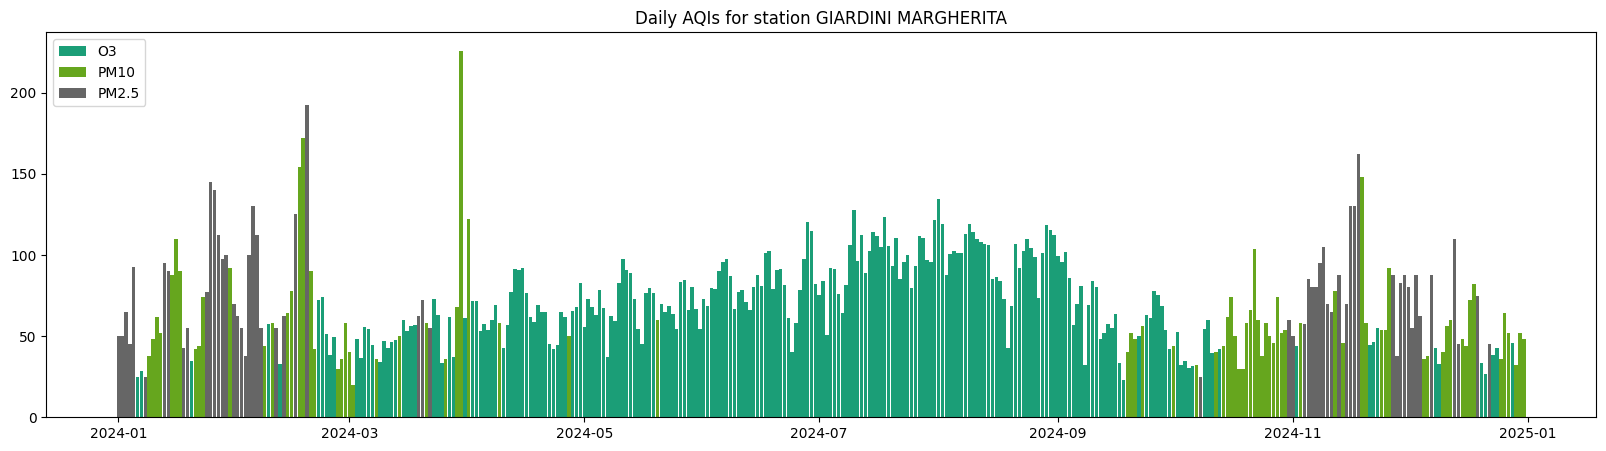

Station PORTA SAN FELICE AQI:


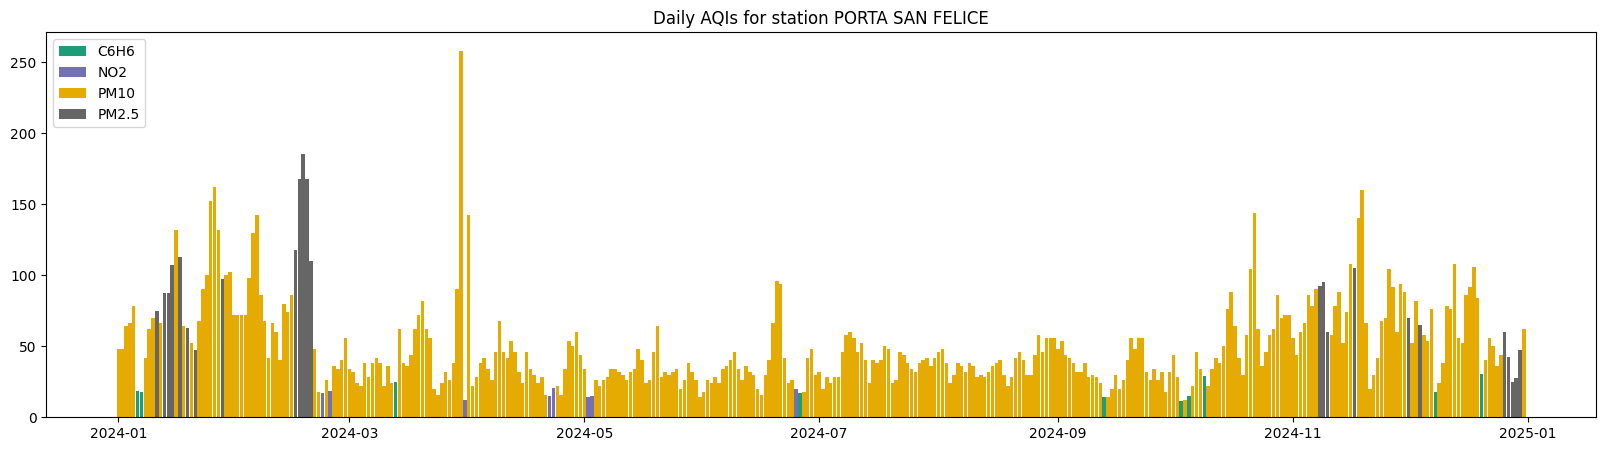

Station VIA CHIARINI AQI:


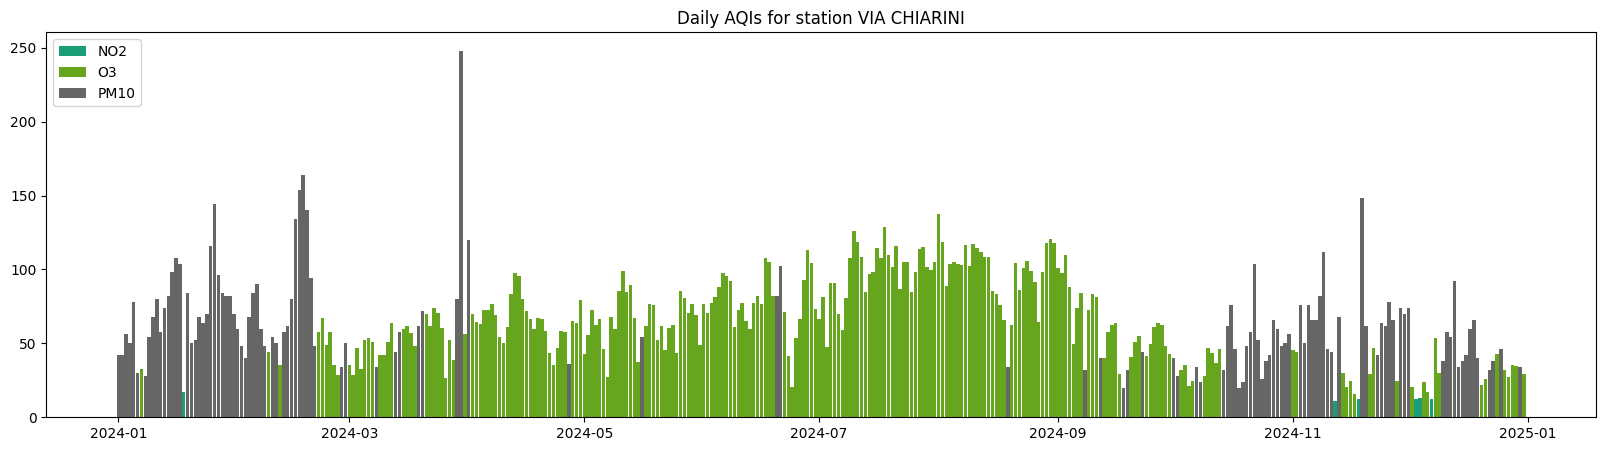

In [57]:
start=datetime(2024,1,1)
end=datetime(2024,12,31)

for station in station_AQIs_daily:
    print(f'Station {station} AQI:')

    plot_AQI(
        station_AQI=[
            station_AQI_daily[station],
        ], 
        title=[
            f'Daily AQIs for station {station}',
        ],
        figsize=(20, 5), s=start, e=end)